In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
penguins = sns.load_dataset('penguins')
data = penguins.dropna()

In [5]:
data['species'] = data['species'].map({'Adelie':0,'Chinstrap':1,'Gentoo':2})
#data['sex']=data['sex'].map({'Male':0,'Female':1})

C:\Users\nimesh\AppData\Local\Temp\ipykernel_192\1116229410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['species'] = data['species'].map({'Adelie':0,'Chinstrap':1,'Gentoo':2})


In [6]:
targets = np.asarray(data['species'])
marker_style = ['o','s','^']
target_names = ['Adelie', 'Chinstrap','Gentoo']

In [7]:
data.drop(['island'],axis=1,inplace=True)
data.drop('sex',inplace=True,axis=1)

C:\Users\nimesh\AppData\Local\Temp\ipykernel_192\3007843347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['island'],axis=1,inplace=True)
C:\Users\nimesh\AppData\Local\Temp\ipykernel_192\3007843347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('sex',inplace=True,axis=1)


In [8]:
features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
       'body_mass_g']
X = data[features]
y = data['species']

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Standardizing the features (optional but recommended for LDA)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Create and fit the LDA model
# lda = LinearDiscriminantAnalysis()
# X_train_lda = lda.fit_transform(X_train_scaled, y_train)
# X_test_lda = lda.transform(X_test_scaled)

# # Make predictions
# y_pred = lda.predict(X_test_scaled)

# # Evaluate model performance
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# # Plotting the data in 2D
# plt.figure(figsize=(10, 7))
# for i, target_name in enumerate(set(y)):
#     plt.scatter(X_train_lda[y_train == target_name, 0], X_train_lda[y_train == target_name, 1], alpha=0.8, label=f"Class {target_name}")
# plt.legend()
# plt.title('LDA: 2D Projection')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.grid(True)
# plt.show()

# # If you have more than 2 components, you can plot in 3D (optional)
# if X_train_lda.shape[1] > 2:
#     from mpl_toolkits.mplot3d import Axes3D

#     fig = plt.figure(figsize=(10, 7))
#     ax = fig.add_subplot(111, projection='3d')
#     for i, target_name in enumerate(set(y)):
#         ax.scatter(X_train_lda[y_train == target_name, 0], X_train_lda[y_train == target_name, 1], X_train_lda[y_train == target_name, 2], alpha=0.8, label=f"Class {target_name}")
#     ax.set_title('LDA: 3D Projection')
#     ax.set_xlabel('Component 1')
#     ax.set_ylabel('Component 2')
#     ax.set_zlabel('Component 3')
#     ax.legend()
#     plt.show()# 

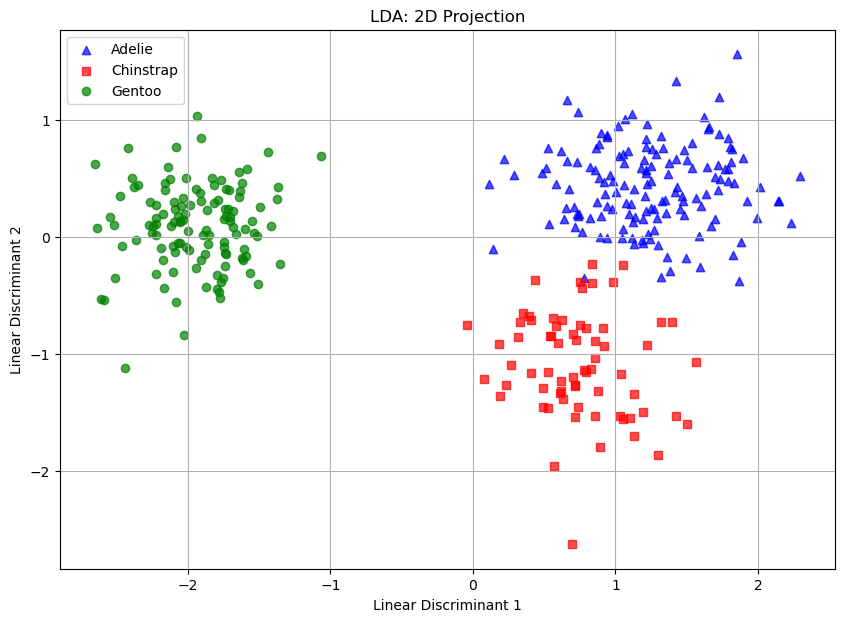

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Step 1: Compute the class mean vectors
class_labels = np.unique(y)
mean_vectors = []
for cl in class_labels:
    mean_vectors.append(np.mean(X_scaled[y.values == cl], axis=0))

# Step 2: Compute the within-class scatter matrix
d = X_scaled.shape[1]  # number of features
S_W = np.zeros((d, d))
for cl, mv in zip(class_labels, mean_vectors):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for index, row in X_scaled[y.values == cl].iterrows():
        row_values = row.values.reshape(-1, 1)  # Convert the row to a column vector
        mv_values = mv.values.reshape(-1, 1)    # Convert mv to a column vector
        class_scatter += (row_values - mv_values).dot((row_values - mv_values).T)
    S_W += class_scatter  # sum class scatter matrices

# Step 3: Compute the between-class scatter matrix
overall_mean = np.mean(X_scaled, axis=0).values  # Convert Series to NumPy array
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vectors):
    n = X_scaled[y.values == class_labels[i]].shape[0]
    mean_vec_values = mean_vec.values.reshape(-1, 1)  # Convert mean_vec to a column vector
    overall_mean_values = overall_mean.reshape(-1, 1)  # Convert overall_mean to a column vector
    S_B += n * (mean_vec_values - overall_mean_values).dot((mean_vec_values - overall_mean_values).T)

# Step 4: Solve the generalized eigenvalue problem for the matrix S_W^(-1) S_B
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

# Step 5: Sort the eigenvectors by eigenvalues in descending order
eigen_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:, i]) for i in range(len(eigen_values))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Choose the top k eigenvectors (k = 2 in this case)
W = np.hstack((eigen_pairs[0][1].reshape(d, 1), eigen_pairs[1][1].reshape(d, 1)))

# Step 6: Transform the data
X_lda = X_scaled.dot(W).values  # Convert to NumPy array

# Plotting the transformed data in 2D
plt.figure(figsize=(10, 7))
for label, marker, color in zip(class_labels, ('^', 's', 'o'), ('blue', 'red', 'green')):
    plt.scatter(x=X_lda[y.values == label, 0],
                y=X_lda[y.values == label, 1],
                marker=marker,
                color=color,
                alpha=0.7,
                label=target_names[label])
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.legend(loc='best')
plt.title('LDA: 2D Projection')
plt.grid(True)
plt.show()

In [12]:
class_labels = np.unique(y)
mean_vectors = []
for cl in class_labels:
    mean_vectors.append(np.mean(X_scaled[y.values == cl], axis=0))

# Step 2: Compute the within-class scatter matrix
d = X_scaled.shape[1]  # number of features
S_W = np.zeros((d, d))
for cl, mv in zip(class_labels, mean_vectors):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for index, row in X_scaled[y.values == cl].iterrows():
        row_values = row.values.reshape(-1, 1)  # Convert the row to a column vector
        mv_values = mv.values.reshape(-1, 1)    # Convert mv to a column vector
        class_scatter += (row_values - mv_values).dot((row_values - mv_values).T)
    S_W += class_scatter  # sum class scatter matrices

# Step 3: Compute the between-class scatter matrix
overall_mean = np.mean(X_scaled, axis=0).values  # Convert Series to NumPy array
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vectors):
    n = X_scaled[y.values == class_labels[i]].shape[0]
    mean_vec_values = mean_vec.values.reshape(-1, 1)  # Convert mean_vec to a column vector
    overall_mean_values = overall_mean.reshape(-1, 1)  # Convert overall_mean to a column vector
    S_B += n * (mean_vec_values - overall_mean_values).dot((mean_vec_values - overall_mean_values).T)

# Step 4: Solve the generalized eigenvalue problem for the matrix S_W^(-1) S_B
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

# Step 5: Sort the eigenvectors by eigenvalues in descending order
eigen_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:, i]) for i in range(len(eigen_values))]
print(eigen_pairs)
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print(eigen_pairs)
W = np.hstack((eigen_pairs[0][1].reshape(d, 1), eigen_pairs[1][1].reshape(d, 1)))
W

[(15.030390411244795, array([-0.17748191,  0.77475153, -0.44759925, -0.40977451])), (2.336239277497804, array([-0.85665065, -0.00771756,  0.0750752 ,  0.51034677])), (4.2041222387131197e-16, array([ 0.03968407, -0.7223493 , -0.05568929, -0.68813906])), (1.0135497604255768e-15, array([ 0.18433983, -0.37811322, -0.82336941,  0.38093573]))]
[(15.030390411244795, array([-0.17748191,  0.77475153, -0.44759925, -0.40977451])), (2.336239277497804, array([-0.85665065, -0.00771756,  0.0750752 ,  0.51034677])), (1.0135497604255768e-15, array([ 0.18433983, -0.37811322, -0.82336941,  0.38093573])), (4.2041222387131197e-16, array([ 0.03968407, -0.7223493 , -0.05568929, -0.68813906]))]


array([[-0.17748191, -0.85665065],
       [ 0.77475153, -0.00771756],
       [-0.44759925,  0.0750752 ],
       [-0.40977451,  0.51034677]])

In [ ]:
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load the penguins dataset and drop any rows with missing values
# penguins = sns.load_dataset('penguins')
# data = penguins.dropna()

# # Map species names to numerical values
# data['species'] = data['species'].map({'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2})

# # Extract the target variable
# targets = np.asarray(data['species'])
# marker_style = ['o', 's', '^']
# target_names = ['Adelie', 'Chinstrap', 'Gentoo']

# # Drop unnecessary columns
# data.drop(['island'], axis=1, inplace=True)
# data.drop('sex', inplace=True, axis=1)

# # Define features and target variable
# features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
# X = data[features]
# y = data['species']

# # Standardize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# # Step 1: Compute the class mean vectors
# class_labels = np.unique(y)
# mean_vectors = []
# for cl in class_labels:
#     mean_vectors.append(np.mean(X_scaled[y.values == cl], axis=0))

# # Step 2: Compute the within-class scatter matrix
# d = X_scaled.shape[1]  # number of features
# S_W = np.zeros((d, d))
# for cl, mv in zip(class_labels, mean_vectors):
#     class_scatter = np.zeros((d, d))  # scatter matrix for each class
#     for index, row in X_scaled[y.values == cl].iterrows():
#         row_values = row.values.reshape(-1, 1)  # Convert the row to a column vector
#         mv_values = mv.values.reshape(-1, 1)    # Convert mv to a column vector
#         class_scatter += (row_values - mv_values).dot((row_values - mv_values).T)
#     S_W += class_scatter  # sum class scatter matrices

# # Step 3: Compute the between-class scatter matrix
# overall_mean = np.mean(X_scaled, axis=0).values  # Convert Series to NumPy array
# S_B = np.zeros((d, d))
# for i, mean_vec in enumerate(mean_vectors):
#     n = X_scaled[y.values == class_labels[i]].shape[0]
#     mean_vec_values = mean_vec.values.reshape(-1, 1)  # Convert mean_vec to a column vector
#     overall_mean_values = overall_mean.reshape(-1, 1)  # Convert overall_mean to a column vector
#     S_B += n * (mean_vec_values - overall_mean_values).dot((mean_vec_values - overall_mean_values).T)

# # Step 4: Solve the generalized eigenvalue problem for the matrix S_W^(-1) S_B
# eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

# # Step 5: Sort the eigenvectors by eigenvalues in descending order
# eigen_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:, i]) for i in range(len(eigen_values))]
# eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# # Choose the top k eigenvectors (k = 2 in this case)
# W = np.hstack((eigen_pairs[0][1].reshape(d, 1), eigen_pairs[1][1].reshape(d, 1)))

# # Step 6: Transform the data
# X_lda = X_scaled.dot(W).values  # Convert to NumPy array

# # Plotting the transformed data in 2D
# plt.figure(figsize=(10, 7))
# for label, marker, color in zip(class_labels, ('^', 's', 'o'), ('blue', 'red', 'green')):
#     plt.scatter(x=X_lda[y.values == label, 0],
#                 y=X_lda[y.values == label, 1],
#                 marker=marker,
#                 color=color,
#                 alpha=0.7,
#                 label=f'Class {label}')
# plt.xlabel('Linear Discriminant 1')
# plt.ylabel('Linear Discriminant 2')
# plt.legend(loc='best')
# plt.title('LDA: 2D Projection')
# plt.grid(True)
# plt.show()
